In [1]:
### RUN EVERY TIME: ECONOMIC INDICES RELEASES HISTORY EXTRACTING

In [2]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
import numpy as np
from datetime import date, datetime
from math import floor, ceil
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#from statsmodels.tsa.x13 import x13_arima_analysis
from itertools import combinations_with_replacement
from sklearn.decomposition import PCA
import os
import gc
#from joblib import Parallel, delayed
import re

#%load_ext line_profiler

In [3]:
### RUN ONLY WHEN ARIMA X13 SA LAUNCHING 

### Warnings hiding:
import warnings
warnings.filterwarnings('ignore')
### Seasonal adjustment module paths set up:
%env X13PATH = C:\Users\ighar\AppData\Roaming\jupyter\x13as
%env X12PATH = C:\Users\ighar\AppData\Roaming\jupyter\x13as
#%env

env: X13PATH=C:\Users\ighar\AppData\Roaming\jupyter\x13as
env: X12PATH=C:\Users\ighar\AppData\Roaming\jupyter\x13as


In [4]:
## VERSION CONTROL

from platform import python_version
print('pandas version: ', pd.__version__)
print('python version: ', python_version())

pandas version:  0.25.3
python version:  3.7.4


In [5]:
### RUN EVERY TIME: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable']
### Raw data path and sheets:
str_path_bb_idx_source = 'Data_Files/Source_Files/Bloomberg_Eco_Indices.xlsx'
str_us_sheet = 'US Eco Const'
str_all_sheet = 'All Eco Const'
### Flags data path and sheets:
str_path_bb_idx_flags = 'Data_Files/Source_Files/Bloomberg_Eco_Flags_Extended.xlsx'
str_flag_sheet = 'Bloomberg Description'
### PC FPC weights collection:
str_path_fpc_hdf = 'Data_Files/Source_Files/FPC_Weights.h5'
str_weights_key = 'global_diagonal_full_mom' # 'global_diagonal_full_yoy'
### Source data constants:
int_idx_cols = 12
### HDF file with converted source data:
str_path_bb_fcast_hdf = 'Data_Files/Source_Files/Bloomberg_Forecasts.h5'
str_key_flags = 'flags_exported' ### Acadian flags list
str_key_exported = 'all_idx_exported' ### Raw export with only replacing zero dates and after 2021-01-01 dates with np.NaN
str_key_raw_filled = 'all_idx_raw_filled' ### Raw export with initial dates, dates gaps, absent date coluns filled
str_key_surprise_source = 'surprise_source'
str_key_stdev_source = 'stdev_source'
### Observation axis range:
datetime_start = datetime(1984, 12, 31) # Start date for efficacy measures
date_start = datetime_start.date()
datetime_end = datetime(2020, 8, 31) # End date for efficacy measures
date_end = datetime_end.date()
idx_date_range = pd.date_range(date_start, date_end, freq = 'B')
datetime_basis = datetime(1993, 12, 31) # End date for efficacy measures
date_basis = datetime_basis.date()
### Gaps filling options:
int_revision_shift = 1
int_final_shift = 2
int_first_mean_length = 12
dict_final_only_lag = {}
dict_final_only_lag['Quarterly'] = 90 // 2
dict_final_only_lag['Monthly'] = 30 // 2
dict_final_only_lag['Other'] = 7 // 2
### Cumprod shifts for monthly data frequency:
dict_cumprod_step = {}
dict_cumprod_step['MoM%'] = 1
dict_cumprod_step['QoQ%'] = 3
dict_cumprod_step['YoY%'] = 12
### Stock-like series shifts for YoY transformation:
dict_yoy_shift = {}
dict_yoy_shift['Monthly'] = 12
dict_yoy_shift['Quarterly'] = 4
dict_yoy_shift['Other'] = 52
### Stock-like series shifts for QoQ transformation:
dict_qoq_shift = {}
dict_qoq_shift['Monthly'] = 4
dict_qoq_shift['Other'] = 13
### Stock-like series shifts for MoM transformation:
dict_mom_shift = {}
dict_mom_shift['Monthly'] = 1
dict_mom_shift['Other'] = 4
### Group tickers rebasing options:
int_not_to_rebase_term = 7 ### Term in years for min ticker data date when we do not need to rebase it with basis group ticker
int_not_to_rebase_diff = 2 ### Minimal difference in years between basis ticker and other group ticker min date when we need to rebase group ticker
### Z-scoring options:
int_winsorize_bound = 4
flo_winsorize_tolerance = 0.0001
int_winsorize_steps_limit = 5
### Diagonal options:
int_min_years_z_score = 3
int_max_years_z_score = 10
date_diag_start = datetime(1994, 1, 1)
### Data filling limit
int_fill_limit = 20
### Average region correlation matrix weight for daily correlation matrix shrinking:
flo_reg_weight = 0.5
### Regions weights:
dict_region_weight = {}
dict_region_weight['US'] = 0.50
dict_region_weight['Europe'] = 0.25
dict_region_weight['Japan'] = 0.15
dict_region_weight['UK'] = 0.10
### Business year length:
int_bus_year = 260
### Rolling correlation tail length:
int_corr_tail = 5
### A-la Newey-West adjustment maximum lag:
int_n_w_lag = 4
### Covariance subsamples number:
int_cov_samples = 22
### Minimal years to use column for PCA performing:
int_min_years_pca = 7
### CPU count to use during multiprocessing:
int_cpu_count = 4
### NBER Source file:
str_path_nber_source = 'Data_Files/Source_Files/NBER_Chronology.xlsx'
### NBER Recession periods collection:
str_path_nber_hdf = 'Data_Files/Source_Files/NBER_Chronology.h5'
str_nber_periods_key = 'nber_recession_periods'
### CFNAI Source file:
str_path_cfnai_source = 'Data_Files/Source_Files/CFNAI.xlsx'
### CFNAI data collection:
str_path_cfnai_hdf = 'Data_Files/Source_Files/CFNAI.h5'
str_cfnai_full_key = 'cfnai_all_indices'
### MSCI World Index Source file:
str_path_msci_source = 'Data_Files/Source_Files/MSCI_World_Index.xlsx'
### MSCI World Index data collection:
str_path_msci_hdf = 'Data_Files/Source_Files/MSCI_World_Index.h5'
str_msci_world_key = 'msci_world'
str_msci_market_down_key = 'msci_recession_periods'

In [6]:
### DEFINING OBSERVATION DATE VECTOR EXTRACTION

def get_obs_date_vector(str_ticker, str_date, bool_exact_date = False, bool_drop_levels = False):
    ### Vector for exact date:
    if bool_exact_date:
        ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
    ### Vector for nearest date:        
    else:
        ### Loading full ticker series:        
        ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
        ### Extracting data for max date less or equal to needed date:
        ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
    ### Dropping constant index levels if needed:
    if bool_drop_levels:
        return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
    else:
        return ser_obs_date

In [7]:
### DEFINING WEIGHTED AVERAGE FOR DATAFRAME COLUMNS (PART OF THE PRODUCT CODE)

def columns_average(df_series, list_weights = False): 
    ### Single column check
    if (len(df_series.columns) > 1):
        ### Equal weights list creating:
        if isinstance(list_weights, bool):
            list_weights = [1] * len(df_series.columns)
        ### Dataframe of weights initialising:
        df_weights = pd.DataFrame(np.NaN, index = df_series.index, columns = df_series.columns)
        for iter_num, iter_col in enumerate(df_weights.columns):
            df_weights[iter_col] = list_weights[iter_num]
        ### Zeroing weights for NaN values:
        for iter_col in df_weights.columns:
            df_weights.loc[df_series[iter_col].isna(), iter_col] = 0
        ser_mean = (df_series.multiply(df_weights).sum(axis = 1)).div(df_weights.sum(axis = 1))    
        ### Results output:
        del df_series
        del df_weights    
        gc.collect()
    else:
        ser_mean = df_series.squeeze()
        del df_series
        gc.collect()        
    return ser_mean

In [8]:
### RUN TO RE-EXPORT DATA: SOURCE FILE EXPORT

### Reading excel file:
df_all_idx_raw = pd.read_excel(io = str_path_bb_idx_source, sheet_name = str_all_sheet, skiprows = [0], index_col = None, header = None, parse_dates = True,
                               na_values = list_na_excel_values, keep_default_na = False)
### List of dataframes for each eco index initializing:
list_idx_raw = []
### Extracting and converting each eco index data block seperately to proper form:
for int_iter_idx_col in range(len(df_all_idx_raw.columns) // int_idx_cols):
    ### Extracting raw data:
    df_iter_idx_raw = df_all_idx_raw.iloc[All, (int_iter_idx_col * int_idx_cols) : ((int_iter_idx_col + 1) * int_idx_cols) - 1]
    ### Assigning colum names:
    df_iter_idx_raw.columns = df_iter_idx_raw.iloc[1]
    df_iter_idx_raw.columns.name = ''    
    ### Dropping empty rows:
    df_iter_idx_raw.dropna(how = 'all', inplace = True)
    ### Extracting eco index name:
    df_iter_idx_raw['Index_Name'] = df_iter_idx_raw.iloc[0, 0]
    ### Dropping identification rows (no longer needed):
    df_iter_idx_raw.drop([0, 1], axis = 0, inplace = True)
    ### Setting multiindex:
    df_iter_idx_raw.set_index(['Date', 'Index_Name'], drop = True, append = False, inplace = True)
    ### ADding dataframe to list:
    list_idx_raw.append(df_iter_idx_raw)
### Exported data aggregating:
df_all_idx_exported = pd.concat(list_idx_raw, axis = 0).swaplevel()
### Exported data saving:
df_all_idx_exported.index.names = ['Index_Name', 'Data_Date']
### Types converting for numerical data:
df_all_idx_exported = df_all_idx_exported.astype({'PX_LAST': 'float',
                                                  'ACTUAL_RELEASE': 'float',
                                                  'FIRST_REVISION': 'float',
                                                  'BN_SURVEY_NUMBER_OBSERVATIONS': 'float',
                                                  'BN_SURVEY_MEDIAN': 'float',
                                                  'BN_SURVEY_AVERAGE': 'float',
                                                  'FORECAST_STANDARD_DEVIATION': 'float',
                                                 })
### Zero dates dropping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] == 0, ['ECO_RELEASE_DT']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] == 0, ['FIRST_REVISION_DATE']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] == 0, ['ECO_FUTURE_RELEASE_DATE']] = np.NaN
### Incorrect dates droppping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] > 20210000, 'ECO_RELEASE_DT'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] > 20210000, 'FIRST_REVISION_DATE'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] > 20210000, 'ECO_FUTURE_RELEASE_DATE'] = np.NaN
### Dates formatting:
df_all_idx_exported['ECO_RELEASE_DT'] = pd.to_datetime(df_all_idx_exported['ECO_RELEASE_DT'].astype(str), format = '%Y%m%d')
df_all_idx_exported['FIRST_REVISION_DATE'] = pd.to_datetime(df_all_idx_exported['FIRST_REVISION_DATE'].astype(str), format = '%Y%m%d')
df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] = pd.to_datetime(df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'].astype(str), format = '%Y%m%d')
### Exported dataframe saving:
df_all_idx_exported.to_hdf(str_path_bb_fcast_hdf, key = str_key_exported, mode = 'w')

In [9]:
### RUN TO RE-EXPORT DATA: FLAGS FILE EXPORT

### Reading excel file:
df_flags = pd.read_excel(io = str_path_bb_idx_flags, sheet_name = str_flag_sheet, usecols = list(range(38))[1: ], index_col = 0, skiprows = list(range(6)), header = 0,
                               parse_dates = True, na_values = list_na_excel_values, keep_default_na = False)
### Dataframe transforming:
df_flags.dropna(how = 'all', inplace = True)
df_flags.index.name = 'Index_Name'
### Choosing columns to go on with:
df_flags = \
        df_flags[['CTRY', 'Type', 'Category', 'Negative', 'Security Description', 'SA/NSA', 'Processing', 'Index: Base', 'Type 2', 'INDX_SOURCE', 'DES_NOTES', 'INDX_FREQ']]
### Columns renaming:
df_flags.columns = ['Region', 'Type_Prime', 'Category', 'Negative', 'Description', 'SA_Status', 'Processing', 'Base', 'Type_Second', 'Data_Source', 'Notes', 'Frequency']
### Seasonality Adjustment Flag filling:
df_flags['SA_Status'] = df_flags['SA_Status'].fillna('Unclear')
### Processing Index separating:
df_flags['Processing'] = df_flags['Processing'].str.partition(': ')[0].str.strip()
### Base filling:
df_flags['Base'] = df_flags['Base'].fillna(-1)
### Euro countries region renaming:
df_flags.loc[~df_flags['Region'].isin(['Japan', 'UK', 'US']), 'Region'] = 'Europe'
### Columns reordering:
df_flags = df_flags[['Type_Prime', 'Type_Second', 'Category', 'Region', 'Processing', 'Base', 'SA_Status', 'Frequency', 'Negative', 'Description', 'Data_Source', 'Notes']]
### Types converting:
df_flags = df_flags.astype({'Type_Prime': 'str',
                            'Type_Second': 'str',
                            'Category': 'str',
                            'Region': 'str',
                            'Processing': 'str',
                            'Base': 'int',
                            'SA_Status': 'str',
                            'Frequency': 'str',
                            'Negative': 'int',
                            'Description': 'str',
                            'Data_Source': 'str',
                            'Notes': 'str'})
### Sub Type info adding:
df_flags['Sub_Type'] = df_flags['Type_Second']
df_flags.loc[(df_flags['Type_Prime'] == 'INF') & (df_flags['Type_Second'].isin(['CPI', 'ICP', 'RPI'])), 'Sub_Type'] = 'CPI'
df_flags.loc[(df_flags['Type_Prime'] == 'OUT') & (df_flags['Type_Second'].isin(['IndSales', 'Prod'])), 'Sub_Type'] = 'Prod'
df_flags.loc[(df_flags['Type_Prime'] == 'CON') & (df_flags['Type_Second'].isin(['Cons', 'Sales'])), 'Sub_Type'] = 'Cons'
df_flags.loc[(df_flags['Type_Prime'] == 'ANT') & (df_flags['Type_Second'].isin(['Bus', 'PMI'])), 'Sub_Type'] = 'Bus'
df_flags.loc[(df_flags['Type_Prime'] == 'ANT'), 'Category'] = 'Leading'
### Exported dataframe saving:
df_flags.to_hdf(str_path_bb_fcast_hdf, key = str_key_flags, mode = 'a')

In [10]:
### RUN TO RE-EXPORT DATA: RELEASES AND REVISIONS DATA EXTRACTING

### Revisions data reading (99,180 rows):
df_all_idx_revisions = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_exported)[
                       ['PX_LAST', 'ECO_RELEASE_DT', 'ACTUAL_RELEASE', 'FIRST_REVISION_DATE', 'FIRST_REVISION', 'ECO_FUTURE_RELEASE_DATE', 
                        'BN_SURVEY_NUMBER_OBSERVATIONS', 'BN_SURVEY_MEDIAN', 'BN_SURVEY_AVERAGE', 'FORECAST_STANDARD_DEVIATION']]
### Dropping rows with all Index Values missed (96,369 rows left):
#df_all_idx_revisions = \
#        df_all_idx_revisions.loc[df_all_idx_revisions['PX_LAST'].notna() | df_all_idx_revisions['ACTUAL_RELEASE'].notna() | df_all_idx_revisions['FIRST_REVISION'].notna()]
### Date filtering:
df_all_idx_revisions = df_all_idx_revisions.reset_index('Data_Date')
df_all_idx_revisions = df_all_idx_revisions.loc[df_all_idx_revisions['Data_Date'] >= datetime_start].set_index('Data_Date', append = True)
### Columns renaming:
df_all_idx_revisions.columns = ['Final_Value', 'Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Future_Date', 
                                'Observations_Number', 'Survey_Median', 'Survey_Average', 'Forecast_Std']

In [11]:
### RUN TO RE-EXPORT DATA: DATA REPAIRING

### 1 : MPMIITMA Index Revision_Value mistake correction:
df_all_idx_revisions.loc[('MPMIITMA Index', All), 'Revision_Value'] = np.NaN
### 2 : JNCPT Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNCPT Index', '1999-07-31'), 'Release_Date'] = pd.to_datetime('1999-07-30')
df_all_idx_revisions.loc[('JNCPT Index', '2001-01-31'), 'Release_Date'] = pd.to_datetime('2001-01-26')
df_all_idx_revisions.loc[('JNCPT Index', '2001-02-28'), 'Release_Date'] = pd.to_datetime('2001-03-02')
df_all_idx_revisions.loc[('JNCPT Index', '2001-06-30'), 'Release_Date'] = pd.to_datetime('2001-06-29')
### 3 : JNCSTOTY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNCSTOTY Index', '2018-12-31'), 'Release_Date'] = pd.to_datetime('2019-01-31')
### 4: JNPIY Index Revision_Date mistakes correction:
df_all_idx_revisions.loc[('JNPIY Index', '2015-12-31'), 'Revision_Date'] = pd.to_datetime('2016-02-23')
### 5: JNPIY Index Revision_Date mistakes correction:
df_all_idx_revisions.loc[('JNTIAIAM Index', '2017-11-30'), 'Revision_Date'] = pd.to_datetime('2018-02-20')
### 6: BECPCHNG Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('BECPCHNG Index', '1997-01-31'), 'Release_Date'] = pd.to_datetime('1997-01-30')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-10-31'), 'Release_Date'] = pd.to_datetime('2001-10-28')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-11-30'), 'Release_Date'] = pd.to_datetime('2001-11-29')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-12-31'), 'Release_Date'] = pd.to_datetime('2001-12-23')
### 7 : BEUER Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('BEUER Index', '1997-01-31'), 'Release_Date'] = pd.to_datetime('1997-02-06')
### 8 : FRCPEECM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('FRCPEECM Index', '1997-07-31'), 'Release_Date'] = pd.to_datetime('1997-08-14')
### 9 : FRCPIMOM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('FRCPIMOM Index', '1999-01-31'), 'Release_Date'] = pd.to_datetime('1999-02-24')
df_all_idx_revisions.loc[('FRCPIMOM Index', '1999-02-28'), 'Release_Date'] = pd.to_datetime('1999-03-24')
df_all_idx_revisions.loc[('FRCPIMOM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-02-21')
### 10 : GKCPNEWY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-03-31'), 'Release_Date'] = pd.to_datetime('2001-04-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-04-30'), 'Release_Date'] = pd.to_datetime('2001-05-10')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-05-31'), 'Release_Date'] = pd.to_datetime('2001-06-10')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-06-30'), 'Release_Date'] = pd.to_datetime('2001-07-05')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-07-31'), 'Release_Date'] = pd.to_datetime('2001-08-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-08-31'), 'Release_Date'] = pd.to_datetime('2001-09-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-09-30'), 'Release_Date'] = pd.to_datetime('2001-10-08')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-10-31'), 'Release_Date'] = pd.to_datetime('2001-11-08')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-11-30'), 'Release_Date'] = pd.to_datetime('2001-12-09')
### 11 : GKUERATE Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GKUERATE Index', '2007-01-31'), 'Release_Date'] = np.NaN
### 12 : GRCP2NRM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GRCP2NRM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-01-30')
### 13 : GRCP2SAM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GRCP2SAM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-01-30')
### 14 : ITVHYOY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('ITVHYOY Index', '1999-01-31'), 'Release_Date'] = pd.to_datetime('1999-02-03')
### 15 : JNLSUCTL Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNLSUCTL Index', '2003-01-31'), 'Release_Date'] = pd.to_datetime('2003-03-01')
### 16 : PTCIEC Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('PTCIEC Index', '2007-12-31'), 'Release_Date'] = pd.to_datetime('2008-01-08')
### 17 : SLCPLHMM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SLCPLHMM Index', '2004-04-30'), 'Release_Date'] = pd.to_datetime('2004-05-20')
df_all_idx_revisions.loc[('SLCPLHMM Index', '2005-01-31'), 'Release_Date'] = pd.to_datetime('2005-02-27')
df_all_idx_revisions.loc[('SLCPLHMM Index', '2005-02-28'), 'Release_Date'] = pd.to_datetime('2005-03-16')
### 18 : SPCPEUMM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-01-31'), 'Release_Date'] = pd.to_datetime('2000-02-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-02-29'), 'Release_Date'] = pd.to_datetime('2000-03-14')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-03-31'), 'Release_Date'] = pd.to_datetime('2000-04-11')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-04-30'), 'Release_Date'] = pd.to_datetime('2000-05-11')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-05-31'), 'Release_Date'] = pd.to_datetime('2000-06-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-06-30'), 'Release_Date'] = pd.to_datetime('2000-07-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-07-31'), 'Release_Date'] = pd.to_datetime('2000-08-14')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-08-31'), 'Release_Date'] = pd.to_datetime('2000-09-13')
### 19 : SPROCHNG Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SPROCHNG Index', '2008-01-31'), 'Release_Date'] = pd.to_datetime('2008-02-25')
### 20 : SVAWRYOY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SVAWRYOY Index', '2006-08-31'), 'Release_Date'] = pd.to_datetime('2006-10-15')
df_all_idx_revisions.loc[('SVAWRYOY Index', '2006-09-30'), 'Release_Date'] = pd.to_datetime('2006-11-15')
df_all_idx_revisions.loc[('SVAWRYOY Index', '2006-10-31'), 'Release_Date'] = pd.to_datetime('2006-12-17')
### 21 : INJCJC Index Data Date shifts correction:
df_all_idx_revisions.loc[('INJCJC Index', '2020-08-28'), 'Release_Date'] = np.NaN
str_ei_to_correct = 'INJCJC Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_to_correct = df_ei_to_correct.drop(df_ei_to_correct.loc[df_ei_to_correct.isna().all(axis = 1)].index)
df_ei_to_correct_shifted = df_ei_to_correct.shift(-1)
df_ei_to_correct_shifted.columns = [str_column_name + '_shifted' for str_column_name in df_ei_to_correct_shifted.columns] 
df_ei_corrected = pd.concat([df_ei_to_correct, df_ei_to_correct_shifted], axis = 1)
df_ei_corrected.loc[df_ei_corrected['Final_Value_shifted'].isna() & df_ei_corrected['Revision_Value_shifted'].notna(), 'Revision_Date'] = \
                df_ei_corrected['Revision_Date_shifted']
df_ei_corrected.loc[df_ei_corrected['Final_Value_shifted'].isna() & df_ei_corrected['Revision_Value_shifted'].notna(), 'Revision_Value'] = \
                df_ei_corrected['Revision_Value_shifted']
df_ei_corrected = df_ei_corrected[df_ei_to_correct.columns]
df_ei_corrected = df_ei_corrected.drop(df_ei_corrected[df_ei_corrected['Final_Value'].isna()].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 22 : INJCSP Index Data Date shifts correction:
str_ei_to_correct = 'INJCSP Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct['Final_Value'].isna()].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 23 : ITSR1B Index Data Date shifts correction: 
df_all_idx_revisions = df_all_idx_revisions.drop(index = ('ITSR1B Index', '1992-12-31'))
### 24 : ATIPIMM Index partly dropping due to the gap:
str_ei_to_correct = 'ATIPIMM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2004-04-30')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 25 : ATIPIMM Index partly dropping due to the gap:
str_ei_to_correct = 'GKIPIYOY Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2001-01-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 26 : IEIPIMOM Index partly dropping due to the gap:
str_ei_to_correct = 'IEIPIMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2001-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 27 : ITNHMOM Index partly dropping due to the gap:
str_ei_to_correct = 'ITNHMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2003-03-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 28 : MPMIGBXA Index partly dropping due to the gap:
str_ei_to_correct = 'MPMIGBXA Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2005-07-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 29 : PCE CHNC Index partly dropping due to the gap:
str_ei_to_correct = 'PCE CHNC Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('1999-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 30 : PTPPMOM Index partly dropping due to the gap:
str_ei_to_correct = 'PTPPMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('1999-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 31 : SNTEEUGX Index partly dropping due to the gap:
str_ei_to_correct = 'SNTEEUGX Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2003-01-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 32 : UKISCTMM Index Data Date shifts correction: 
df_all_idx_revisions = df_all_idx_revisions.drop(index = ('UKISCTMM Index', '1992-12-31'))
### 33 : IERSVMOM Index adding missed rows:
str_ei_to_correct = 'IERSVMOM Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2001-01-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2001-02-28')), All] = np.NaN
### 34 : ITNHMOM Index adding missed rows:
str_ei_to_correct = 'ITNHMOM Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2020-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2020-08-31')), All] = np.NaN
### 35 : NEISIYOY Index adding missed rows:
str_ei_to_correct = 'NEISIYOY Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('1999-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('1999-08-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2000-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2000-11-30')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2001-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2002-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2003-07-31')), All] = np.NaN
### 36 : NEISIYOY Index adding missed rows:
str_ei_to_correct = 'MAPMINDX Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-05-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-06-30')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-08-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-09-30')), All] = np.NaN
### 37 : COMFCOMF Index values correcting:
str_ei_to_correct = 'COMFCOMF Index'
df_ei_to_correct = df_all_idx_revisions.copy().loc[(str_ei_to_correct, All), All]
df_ei_to_correct.loc[df_ei_to_correct['Release_Value'] < 10, 'Release_Value'] = (1 + df_ei_to_correct['Release_Value'] / 100) * 50
df_ei_to_correct.loc[df_ei_to_correct['Revision_Value'] < 10, 'Revision_Value'] = (1 + df_ei_to_correct['Revision_Value'] / 100) * 50
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_to_correct], axis = 0).sort_index()

In [12]:
### RUN TO RE-EXPORT DATA: EXTRACTING RELEASE AND FIRST REVISION DATE/VALUE PAIRS:

### Release data extracting:
df_release_based = df_all_idx_revisions[['Release_Date', 'Release_Value']]
df_release_based.columns = ['Observation_Date', 'Index_Value']
### All empty release date vector Eco Indices:
ser_empty_release_date = df_release_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_release_date = ser_empty_release_date[ser_empty_release_date == 0]
### All empty release value vector Eco Indices:
ser_empty_release_value = df_release_based['Index_Value'].groupby('Index_Name').count()
ser_empty_release_value = ser_empty_release_value[ser_empty_release_value == 0]
### All empty release date or all empty release value indices list:
list_empty_release = sorted(list(set(ser_empty_release_date.index).union(set(ser_empty_release_value.index))))
### Revision data extracting:
df_revision_based = df_all_idx_revisions[['Revision_Date', 'Revision_Value']]
df_revision_based.columns = ['Observation_Date', 'Index_Value']
### All empty first revision date vector Eco Indices:
ser_empty_revision_date = df_revision_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_revision_date = ser_empty_revision_date[ser_empty_revision_date == 0]
### All empty first revision value vector Eco Indices:
ser_empty_revision_value = df_revision_based['Index_Value'].groupby('Index_Name').count()
ser_empty_revision_value = ser_empty_revision_value[ser_empty_revision_value == 0]
### All empty first revision date or all empty first revision value indices list:
list_empty_revision = sorted(list(set(ser_empty_revision_date.index).union(set(ser_empty_revision_value.index))))

In [13]:
### RUN TO RE-EXPORT DATA: ALL DATES FILLING PROCEDURE

df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)

#### Dates filling:
def all_dates_filler(df_eco_ind):
    ### Eco Indice options saving:
    str_index_name = df_eco_ind.index.get_level_values(0)[0]
    str_eco_ind_freq = df_flags.loc[str_index_name, 'Frequency']
    if (str_eco_ind_freq in dict_final_only_lag.keys()):
        int_final_only_lag = dict_final_only_lag[str_eco_ind_freq]
    else:
        int_final_only_lag = dict_final_only_lag['Other']
    ### Index_Name level dropping:
    df_eco_ind = df_eco_ind.droplevel(0)
    ### Index duplicating to column:
    df_eco_ind['Event_Date'] = df_eco_ind.index
    df_eco_ind['Release_Lag'] = np.NaN
    ### No release checking:
    if (str_index_name in list_empty_release): 
        df_eco_ind['Final_Date'] = df_eco_ind['Event_Date'] + pd.Timedelta(int_final_only_lag, 'D')
    elif (str_index_name in list_empty_revision):    
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        df_first_released = df_eco_ind.dropna(subset = ['Release_Date']).iloc[ : int_first_mean_length]        
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date by lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)   
    else:
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        df_first_released = df_eco_ind.dropna(subset = ['Release_Date']).iloc[ : int_first_mean_length]     
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1        
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date with lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Filling empty revision dates: 
        df_eco_ind.loc[df_eco_ind['Revision_Date'].isna(), 'Revision_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_final_shift)
    ### Last values having revision date with no revision value managing:
    idx_last_values = df_eco_ind['Revision_Date'].notna() & df_eco_ind['Revision_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Revision_Value'] = df_eco_ind['Final_Value']
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having release date with no release value managing:
    idx_last_values = df_eco_ind['Release_Date'].notna() & df_eco_ind['Release_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Release_Value'] = df_eco_ind['Final_Value']
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and future date managing (no news detected):
    idx_last_values = df_eco_ind['Future_Date'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and having revision pair managing (no news detected):
    idx_last_values = df_eco_ind['Revision_Date'].notna() & df_eco_ind['Revision_Value'].notna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and no revision pair managing:
    idx_last_values = df_eco_ind['Revision_Date'].isna() & df_eco_ind['Revision_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Date'] = df_eco_ind['Future_Date']    
    ### Results ouput:
    return df_eco_ind[['Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Final_Date', 'Final_Value', 
                       'Observations_Number', 'Survey_Median', 'Survey_Average', 'Forecast_Std']]
### Date filling for each eco index performing:
df_dates_filled = df_all_idx_revisions.groupby('Index_Name').apply(all_dates_filler)

In [14]:
### RUN TO RE-EXPORT DATA: SURVEYS REPAIRING

### 124 : BEBCI Index early Survey_Median values clearing:
df_dates_filled.loc[('BEBCI Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2002, 1, 1)), ['Survey_Average', 'Survey_Median']] = np.NaN
### 125 : BECPCHNG Index all Survey data clearing:
df_dates_filled.loc[('BECPCHNG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 126 : COMFCOMF Index all Survey data clearing:
df_dates_filled.loc[('COMFCOMF Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 127 : ESCPLMOM Index all Survey data clearing:
df_dates_filled.loc[('ESCPLMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 128 : EUBCI Index Survey Error clearing:
df_dates_filled.loc[('EUBCI Index', '2010-12-31'), ['Survey_Average', 'Forecast_Std']] = np.NaN
### 129 : FIBCIND Index all Survey data clearing:
df_dates_filled.loc[('FIBCIND Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 130 : FICCI Index all Survey data clearing:
df_dates_filled.loc[('FICCI Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 131 : FIIPSAIM Index all Survey data clearing:
df_dates_filled.loc[('FIIPSAIM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 132 : FIPPIR2M Index all Survey data clearing:
df_dates_filled.loc[('FIPPIR2M Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 133 : FIRSVYOY Index all Survey data clearing:
df_dates_filled.loc[('FIRSVYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 134 : FIUER Index all Survey data clearing:
df_dates_filled.loc[('FIUER Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 135 : FRCPIMOM Index Survey Error clearing:
df_dates_filled.loc[('FRCPIMOM Index', '2012-01-31'), ['Survey_Average', 'Forecast_Std']] = np.NaN
### 136 : FRJSTCHG Index all Survey data clearing:
df_dates_filled.loc[('FRJSTCHG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 137 : FRPIMOM Index all Survey data clearing:
df_dates_filled.loc[('FRPIMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 138 : GKCPIUHY Index all Survey data clearing:
df_dates_filled.loc[('GKCPNEWY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 139 : GKCPIUHY Index all Survey data clearing:
df_dates_filled.loc[('GKCPNEWY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 140 : GKIPIYOY Index all Survey data clearing:
df_dates_filled.loc[('GKIPIYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 141 : GKRSNEWY Index all Survey data clearing:
df_dates_filled.loc[('GKRSNEWY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 142 : GKUERATE Index all Survey data clearing:
df_dates_filled.loc[('GKUERATE Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 143 : GRCP2NRM Index all Survey data clearing:
df_dates_filled.loc[('GRCP2NRM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 144 : GRWPMOMI Index all Survey data clearing:
df_dates_filled.loc[('GRWPMOMI Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 145 : GRZEEUEX Index all Survey data clearing:
df_dates_filled.loc[('GRZEEUEX Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 146 : IECPEUIQ Index all Survey data clearing:
df_dates_filled.loc[('IECPEUIQ Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 147 : IECPIMOM Index all Survey data clearing:
df_dates_filled.loc[('IECPIMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 148 : IEIPIMOM Index all Survey data clearing:
df_dates_filled.loc[('IEIPIMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 149 : IEPPIEUM Index all Survey data clearing:
df_dates_filled.loc[('IEPPIEUM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 150 : IERSVMOM Index all Survey data clearing:
df_dates_filled.loc[('IERSVMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 151 : IEUELV Index all Survey data clearing:
df_dates_filled.loc[('IEUELV Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 152 : IEUEMOM Index all Survey data clearing:
df_dates_filled.loc[('IEUEMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 153 : IEUERT Index all Survey data clearing:
df_dates_filled.loc[('IEUERT Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 154 : ITISTSAM Index all Survey data clearing:
df_dates_filled.loc[('ITISTSAM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 155 : ITNHMOM Index all Survey data clearing:
df_dates_filled.loc[('ITNHMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 156 : ITORTSAM Index all Survey data clearing:
df_dates_filled.loc[('ITORTSAM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 157 : ITPNIMOM Index all Survey data clearing:
df_dates_filled.loc[('ITPNIMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 158 : ITVHYOY Index all Survey data clearing:
df_dates_filled.loc[('ITVHYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 159 : JCOMACF Index all Survey data clearing:
df_dates_filled.loc[('JCOMACF Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 160 : JCOMHCF Index all Survey data clearing:
df_dates_filled.loc[('JCOMHCF Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 161 : JCPNEFEY Index all Survey data clearing:
df_dates_filled.loc[('JCPNEFEY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 162 : JCPTEFEY Index all Survey data clearing:
df_dates_filled.loc[('JCPTEFEY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 163 : JNCAP Index all Survey data clearing:
df_dates_filled.loc[('JNCAP Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 164 : JNCPT Index early Survey_Median values clearing:
df_dates_filled.loc[('JNCPT Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2001, 1, 1)), ['Survey_Average', 'Survey_Median']] = np.NaN
### 165 : JNCSTOTY Index all Survey data clearing:
df_dates_filled.loc[('JNCSTOTY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 166 : JNCVSSY Index all Survey data clearing:
df_dates_filled.loc[('JNCVSSY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 167 : JNDSNYOY Index all Survey data clearing:
df_dates_filled.loc[('JNDSNYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 168 : JNMTOY Index all Survey data clearing:
df_dates_filled.loc[('JNMTOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 169 : JNPIY Index early Survey_Median values clearing:
df_dates_filled.loc[('JNPIY Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2001, 1, 1)), ['Survey_Average', 'Survey_Median']] = np.NaN
### 169 : JNSBALLI Index all Survey data clearing:
df_dates_filled.loc[('JNSBALLI Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 170 : JNVHPYOY Index all Survey data clearing:
df_dates_filled.loc[('JNVHPYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 171 : JNVHSYOY Index all Survey data clearing:
df_dates_filled.loc[('JNVHSYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 172 : JWCOOVRL Index all Survey data clearing:
df_dates_filled.loc[('JWCOOVRL Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 173 : JWEXOVRL Index all Survey data clearing:
df_dates_filled.loc[('JWEXOVRL Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 174 : MAPMINDX Index all Survey data clearing:
df_dates_filled.loc[('MAPMINDX Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 175 : NECCISA Index all Survey data clearing:
df_dates_filled.loc[('NECCISA Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 176 : NEIP20MM Index all Survey data clearing:
df_dates_filled.loc[('NEIP20MM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 177 : NEPRI Index all Survey data clearing:
df_dates_filled.loc[('NEPRI Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 178 : NERS20Y Index all Survey data clearing:
df_dates_filled.loc[('NERS20Y Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 179 : PLCPMOM Index all Survey data clearing:
df_dates_filled.loc[('PLCPMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 180 : PPI CHNG Index all Survey data clearing:
df_dates_filled.loc[('PPI CHNG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 181 : PTCPHAMM Index all Survey data clearing:
df_dates_filled.loc[('PTCPHAMM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 182 : PTIPTOTM Index all Survey data clearing:
df_dates_filled.loc[('PTIPTOTM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 183 : PXFECHNG Index all Survey data clearing:
df_dates_filled.loc[('PXFECHNG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 184 : SAARDTOT Index all Survey data clearing:
df_dates_filled.loc[('SAARDTOT Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 185 : SKCCCONC Index all Survey data clearing:
df_dates_filled.loc[('SKCCCONC Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 186 : SKCCINDC Index all Survey data clearing:
df_dates_filled.loc[('SKCCINDC Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 187 : SLCPLHMM Index all Survey data clearing:
df_dates_filled.loc[('SLCPLHMM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 188 : SLIPTIYY Index all Survey data clearing:
df_dates_filled.loc[('SLIPTIYY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 189 : SLPPIPMM Index all Survey data clearing:
df_dates_filled.loc[('SLPPIPMM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 190 : SLPRYOYA Index all Survey data clearing:
df_dates_filled.loc[('SLPRYOYA Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 191 : SLRTTXAY Index all Survey data clearing:
df_dates_filled.loc[('SLRTTXAY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 192 : SLWIIYOY Index all Survey data clearing:
df_dates_filled.loc[('SLWIIYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 193 : SPIOWAYY Index all Survey data clearing:
df_dates_filled.loc[('SPIOWAYY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 194 : SPIOYOY Index all Survey data clearing:
df_dates_filled.loc[('SPIOYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 195 : SPIPCCMM Index early Survey_Median values clearing:
df_dates_filled.loc[('SPIPCCMM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2004, 1, 1)), ['Survey_Average', 'Survey_Median']] = np.NaN
### 196 : SPROCHNG Index all Survey data clearing:
df_dates_filled.loc[('SPROCHNG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 197 : SPRSRAY Index all Survey data clearing:
df_dates_filled.loc[('SPRSRAY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 198 : SPRSRGIY Index all Survey data clearing:
df_dates_filled.loc[('SPRSRGIY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 199 : SVCPMOM Index all Survey data clearing:
df_dates_filled.loc[('SVCPMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 200 : UKUEMOM Index all Survey data clearing:
df_dates_filled.loc[('UKUEMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN
### 201 : UKUER Index all Survey data clearing:
df_dates_filled.loc[('UKUER Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN

In [15]:
### RUN TO RE-EXPORT DATA: SURVEYS REPAIRING (COMPATIBILITY WITH RELEASES CORRECTION)

### 202 : PITLCHNG Index outlier values clipping:
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Survey_Median'] < -2), 'Survey_Median'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Survey_Median'] > 2), 'Survey_Median'] = 2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Survey_Average'] < -2), 'Survey_Average'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Survey_Average'] > 2), 'Survey_Average'] = 2.0
### 203 : GRIFPBUS Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift = (df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Release_Value'] - df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] - flo_shift
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] - flo_shift
### 204 : GRIFPCA Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift = (df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Release_Value'] - df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] - flo_shift
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] - flo_shift
### 205 : JNCICCOI Index releases/revisions clearing:
df_dates_filled.loc[('JNCICCOI Index', df_dates_filled.index.get_level_values('Data_Date') <= '2020-01-01'), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN

In [16]:
### RUN TO RE-EXPORT DATA: DATA REPAIRING AND SAVING

### 38 : GKCPIUHY Index Final Date shifts correction: 
df_dates_filled.loc[('GKCPIUHY Index', '2003-10-31'), 'Final_Date'] = pd.to_datetime('2004-02-17')
df_dates_filled.loc[('GKCPIUHY Index', '2003-11-30'), 'Final_Date'] = pd.to_datetime('2004-02-17')
### 39 : GKCPNEWY Index Final Date shifts correction: 
df_dates_filled.loc[('GKCPNEWY Index', '2003-10-31'), 'Final_Date'] = pd.to_datetime('2004-02-10')
df_dates_filled.loc[('GKCPNEWY Index', '2003-11-30'), 'Final_Date'] = pd.to_datetime('2004-02-10')
### 40 : EUCPTSAM Index Final Date shifts correction: 
df_dates_filled.loc[('EUCPTSAM Index', '2004-12-31'), 'Final_Date'] = pd.to_datetime('2005-09-12')
df_dates_filled.loc[('EUCPTSAM Index', '2005-03-31'), 'Final_Date'] = pd.to_datetime('2005-12-09')
df_dates_filled.loc[('EUCPTSAM Index', '2005-06-30'), 'Final_Date'] = pd.to_datetime('2006-03-10')
df_dates_filled.loc[('EUCPTSAM Index', '2005-09-30'), 'Final_Date'] = pd.to_datetime('2006-06-09')
df_dates_filled.loc[('EUCPTSAM Index', '2005-12-31'), 'Final_Date'] = pd.to_datetime('2006-09-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-03-31'), 'Final_Date'] = pd.to_datetime('2006-12-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-06-30'), 'Final_Date'] = pd.to_datetime('2006-12-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-09-30'), 'Final_Date'] = pd.to_datetime('2007-01-18')
### 41 : SVUER Index Revision Date shifts correction: 
df_dates_filled.loc[('SVUER Index', '2005-06-30'), 'Revision_Date'] = pd.to_datetime('2005-09-18')
### 42 : UKMPIMOM Index Revision Date shifts correction: 
df_dates_filled.loc[('UKMPIMOM Index', '2001-01-31'), 'Revision_Date'] = pd.to_datetime('2001-04-09')
df_dates_filled.loc[('UKMPIMOM Index', '2001-02-28'), 'Revision_Date'] = pd.to_datetime('2001-05-08')
df_dates_filled.loc[('UKMPIMOM Index', '2001-03-31'), 'Revision_Date'] = pd.to_datetime('2001-06-11')
df_dates_filled.loc[('UKMPIMOM Index', '2001-04-30'), 'Revision_Date'] = pd.to_datetime('2001-07-10')
df_dates_filled.loc[('UKMPIMOM Index', '2001-05-31'), 'Revision_Date'] = pd.to_datetime('2001-08-05')
df_dates_filled.loc[('UKMPIMOM Index', '2001-08-31'), 'Revision_Date'] = pd.to_datetime('2001-11-05')
df_dates_filled.loc[('UKMPIMOM Index', '2001-10-31'), 'Revision_Date'] = pd.to_datetime('2002-01-14')
### 43 : ESCPLMOM Index early values clearing: 
df_dates_filled.loc[('ESCPLMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1994, 1, 1)), All] = np.NaN
### 44 : ESCPLMOM Index early values clearing: 
df_dates_filled.loc[('ESPPIMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2003, 1, 1)), All] = np.NaN
### 45 : ESCPLMOM Index revisions clearing:
df_dates_filled.loc[('ESPPIMOM Index', All), 'Revision_Value'] = np.NaN
### 46 : IECPIMOM Index early values clearing:
df_dates_filled.loc[('IECPIMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1998, 1, 1)), All] = np.NaN
### 47 : JBTARATE Index early values clearing:
df_dates_filled.loc[('JBTARATE Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1990, 1, 1)), All] = np.NaN
### 48 : SVBTSI Index early values clearing:
df_dates_filled.loc[('SVBTSI Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2005, 1, 1)), All] = np.NaN
### 49 : SVIPTMOM Index early values clearing:
df_dates_filled.loc[('SVIPTMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2008, 1, 1)), All] = np.NaN
### 50 : UKPPIINC Index early values clearing:
df_dates_filled.loc[('UKPPIINC Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1997, 1, 1)), All] = np.NaN
### 51 : UKPPXFBM Index early values clearing:
df_dates_filled.loc[('UKPPXFBM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1997, 1, 1)), All] = np.NaN
### 52 : GRCP2BRM Index outlier values clipping:
df_dates_filled.loc[('GRCP2BRM Index', df_dates_filled['Final_Value'] < -2), 'Final_Value'] = -2.0
### 53 : GRCP2SAM Index outlier values clipping:
df_dates_filled.loc[('GRCP2SAM Index', df_dates_filled['Final_Value'] < -5), 'Final_Value'] = -5.0
df_dates_filled.loc[('GRCP2SAM Index', df_dates_filled['Final_Value'] > 5), 'Final_Value'] = 5.0
### 54 : PITLCHNG Index outlier values clipping:
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Release_Value'] < -2), 'Release_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Release_Value'] > 2), 'Release_Value'] = 2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Revision_Value'] < -2), 'Revision_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Revision_Value'] > 2), 'Revision_Value'] = 2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Final_Value'] < -2), 'Final_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Final_Value'] > 2), 'Final_Value'] = 2.0
### 55 : ITNSSTN Index outlier values clipping:
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Release_Value'] < -10), 'Release_Value'] = -10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Release_Value'] > 10), 'Release_Value'] = 10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Revision_Value'] < -10), 'Revision_Value'] = -10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Revision_Value'] > 10), 'Revision_Value'] = 10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Final_Value'] < -10), 'Final_Value'] = -10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Final_Value'] > 10), 'Final_Value'] = 10.0
### 56 : EUNOEUM Index dropping:
df_dates_filled.drop(labels = 'ESRSREHY Index', level = 'Index_Name', inplace = True)
### 57 : EUNOEUM Index dropping:
df_dates_filled.drop(labels = 'EUNOEUM Index', level = 'Index_Name', inplace = True)
### 58 : NEUETOTR Index dropping:
df_dates_filled.drop(labels = 'NEUETOTR Index', level = 'Index_Name', inplace = True)
### 59 : RSSA25M Index dropping:
df_dates_filled.drop(labels = 'RSSA25M Index', level = 'Index_Name', inplace = True)
### 60 : UKISCTMM Index dropping:
df_dates_filled.drop(labels = 'UKISCTMM Index', level = 'Index_Name', inplace = True)
### 61 : UKMSVTVJ Index dropping:
df_dates_filled.drop(labels = 'UKMSVTVJ Index', level = 'Index_Name', inplace = True)
### 62 : UKNCCCIS Index dropping:
df_dates_filled.drop(labels = 'UKNCCCIS Index', level = 'Index_Name', inplace = True)
### 63 : FRQBMOP3 Index dropping (quarterly frequency):
df_dates_filled.drop(labels = 'FRQBMOP3 Index', level = 'Index_Name', inplace = True)
### 64 : UKBFFTIN Index dropping (quarterly frequency):
df_dates_filled.drop(labels = 'UKBFFTIN Index', level = 'Index_Name', inplace = True)
### 65 : JNSBALLI Index dropping (dead since 2017):
df_dates_filled.drop(labels = 'JNSBALLI Index', level = 'Index_Name', inplace = True)
### 66 : SVUER Index dropping (dead since 2017):
df_dates_filled.drop(labels = 'SVUER Index', level = 'Index_Name', inplace = True)
### 67 : FICCI Index dropping (dead since 2019):
df_dates_filled.drop(labels = 'FICCI Index', level = 'Index_Name', inplace = True)
### 68 : NECCISA Index dropping (dead since 2017):
df_dates_filled.drop(labels = 'NECCISA Index', level = 'Index_Name', inplace = True)
### 69 : UKEGESTG Index dropping (dead since 2018):
df_dates_filled.drop(labels = 'UKEGESTG Index', level = 'Index_Name', inplace = True)
### 70 : SAARDTOT Index dropping (dead since 2018):
df_dates_filled.drop(labels = 'SAARDTOT Index', level = 'Index_Name', inplace = True)
### 71 : CPTICHNG Index finals clearing:
df_dates_filled.loc[('CPTICHNG Index', All), 'Final_Value'] = np.NaN
### 72 : ECO1GFKC Index finals clearing:
df_dates_filled.loc[('ECO1GFKC Index', All), 'Final_Value'] = np.NaN
### 73 : JNPIY Index finals clearing:
df_dates_filled.loc[('JNPIY Index', All), 'Final_Value'] = np.NaN
### 74 : PTCCI Index finals clearing:
df_dates_filled.loc[('PTCCI Index', All), 'Final_Value'] = np.NaN
### 75 : PTPPMOM Index finals clearing:
df_dates_filled.loc[('PTPPMOM Index', All), 'Final_Value'] = np.NaN
### 76 : UKUER Index finals clearing:
df_dates_filled.loc[('UKUER Index', All), 'Final_Value'] = np.NaN
### 77 : UMRTEMU Index finals clearing:
df_dates_filled.loc[('UMRTEMU Index', All), 'Final_Value'] = np.NaN
### 78 : GRIFPBUS Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift = (df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Release_Value'] - df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Final_Value'] = np.NaN
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] - flo_shift
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] - flo_shift
### 79 : GRIFPCA Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift = (df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Release_Value'] - df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Final_Value'] = np.NaN
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] - flo_shift
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] - flo_shift
### 80 : FRJSTCHG Index releases/revisions clearing:
df_dates_filled.loc[('FRJSTCHG Index', All), ['Release_Value', 'Revision_Value']] = np.NaN
### 81 : JNCAP Index releases/revisions clearing:
df_dates_filled.loc[('JNCAP Index', All), ['Release_Value', 'Revision_Value']] = np.NaN
### 82 : IEUERT Index releases/revisions clearing:
df_dates_filled.loc[('IEUERT Index', df_dates_filled.index.get_level_values('Data_Date') <= '2000-01-01'), ['Release_Value', 'Revision_Value']] = np.NaN
### 83 : JNCICCOI Index releases/revisions clearing:
df_dates_filled.loc[('JNCICCOI Index', df_dates_filled.index.get_level_values('Data_Date') <= '2020-01-01'), ['Release_Value', 'Revision_Value']] = np.NaN
### Empty Dates dropping:
df_dates_filled.loc[df_dates_filled['Release_Date'].notna() & df_dates_filled['Release_Value'].isna(), 'Release_Date'] = np.NaN
df_dates_filled.loc[df_dates_filled['Revision_Date'].notna() & df_dates_filled['Revision_Value'].isna(), 'Revision_Date'] = np.NaN
df_dates_filled.loc[df_dates_filled['Final_Date'].notna() & df_dates_filled['Final_Value'].isna(), 'Final_Date'] = np.NaN
### Moving early release dates to data dates:
df_dates_filled.loc[df_dates_filled.index.get_level_values('Data_Date') > df_dates_filled['Release_Date'], 'Release_Date'] = \
    df_dates_filled.loc[df_dates_filled.index.get_level_values('Data_Date') > df_dates_filled['Release_Date']].index.get_level_values('Data_Date')
### Moving early revision dates to data dates:
df_dates_filled.loc[df_dates_filled['Revision_Date'] < df_dates_filled['Release_Date'], 'Revision_Date'] = \
    df_dates_filled.loc[df_dates_filled['Revision_Date'] < df_dates_filled['Release_Date'], 'Release_Date']

In [17]:
### RUN TO TESTING: CHECKING OF PAIR COMPLETENESS

print(df_dates_filled.loc[df_dates_filled['Final_Value'].notna() & df_dates_filled['Final_Date'].isna()])
print(df_dates_filled.loc[df_dates_filled['Final_Value'].isna() & df_dates_filled['Final_Date'].notna()])
print(df_dates_filled.loc[df_dates_filled['Release_Date'].isna() & df_dates_filled['Release_Value'].notna()])
print(df_dates_filled.loc[df_dates_filled['Release_Date'].notna() & df_dates_filled['Release_Value'].isna()])

Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value, Observations_Number, Survey_Median, Survey_Average, Forecast_Std]
Index: []
Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value, Observations_Number, Survey_Median, Survey_Average, Forecast_Std]
Index: []
Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value, Observations_Number, Survey_Median, Survey_Average, Forecast_Std]
Index: []
Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value, Observations_Number, Survey_Median, Survey_Average, Forecast_Std]
Index: []


In [18]:
### RUN TO RE-EXPORT DATA: SURVEYS REPAIRING (FORECAST STD CHECKING)

#display(df_dates_filled[(abs(df_dates_filled['Forecast_Std']) > 50 * abs(df_dates_filled['Survey_Average'] - df_dates_filled['Release_Value'])) & 
#                        (abs(df_dates_filled['Survey_Average'] - df_dates_filled['Release_Value']) > 0.0001)])
#display(df_dates_filled[(abs(df_dates_filled['Forecast_Std']) > 50 * abs(df_dates_filled['Survey_Median'] - df_dates_filled['Release_Value'])) & 
#                        (abs(df_dates_filled['Survey_Median'] - df_dates_filled['Release_Value']) > 0.0001)])

### 206 : GRFRIAMM Index Forecast Std correction:
df_dates_filled.loc[('GRFRIAMM Index', '1996-12-31'), 'Forecast_Std'] = np.NaN

### Dataframe types control:
print(df_dates_filled.dtypes)
### Filled dates saving:
df_dates_filled.to_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled, mode = 'a')

Release_Date           datetime64[ns]
Release_Value                 float64
Revision_Date          datetime64[ns]
Revision_Value                float64
Final_Date             datetime64[ns]
Final_Value                   float64
Observations_Number           float64
Survey_Median                 float64
Survey_Average                float64
Forecast_Std                  float64
dtype: object


Type_Prime                                                   ANT
Type_Second                                                 Cons
Category                                                 Leading
Region                                                        UK
Processing                                                 Index
Base                                                           0
SA_Status                                                Unclear
Frequency                                                Monthly
Negative                                                       0
Description                 GFK UK Consumer Confidence Indicator
Data_Source                                         GfK NOP (UK)
Notes          Consumer confidence tracks sentiment among hou...
Sub_Type                                                    Cons
Name: UKCCI Index, dtype: object


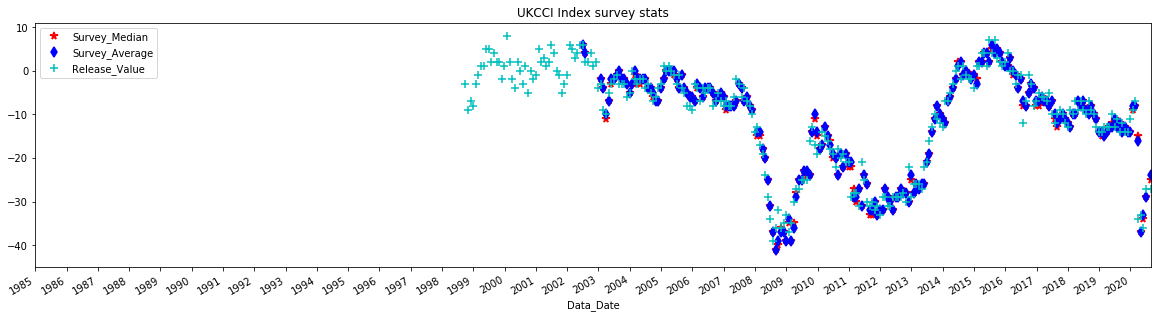

In [20]:
### RUN TO TESTING: FILLED ECO INDICES DATA PLOTTING TO VISUAL CONTROL

### Index choosing:
str_test_index = 'UKCCI Index'
### Data loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
#### Flags printing:
print(df_flags.loc[str_test_index, All])
### Series creating:
if ((len(df_dates_filled.loc[(str_test_index, All), 'Survey_Median'].dropna()) == 0) & (len(df_dates_filled.loc[(str_test_index, All), 'Survey_Average'].dropna()) == 0)):
    print('NO SURVEY DATA HERE!')
df_eco_ind = df_dates_filled.loc[(str_test_index, All), All].droplevel(0)[['Survey_Median', 'Survey_Average', 'Release_Value', 'Revision_Value', 'Final_Value']]    
date_xlim_start = df_eco_ind.index.min()
date_xlim_finish = df_eco_ind.index.max()
#date_xlim_start = datetime(1984, 12, 31)
#date_xlim_finish = datetime(2020, 1, 31)
date_xlim_finish = datetime(2020, 8, 31)
flo_ylim_min = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].min().min()
flo_ylim_max = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].max().max()
tup_ylim = (flo_ylim_min - abs(flo_ylim_min) / 10, flo_ylim_max + abs(flo_ylim_max) / 10)
ax_eco_ind = df_eco_ind[['Survey_Median', 'Survey_Average', 'Release_Value']].plot(figsize = (20, 5), title = str_test_index + ' survey stats', 
                style = ['r*', 'bd', 'c+'], markersize = 7.5, markeredgewidth = 1.5, 
                xlim = (date_xlim_start, date_xlim_finish), ylim = tup_ylim, x_compat = True)
ax_eco_ind.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
ax_eco_ind.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))                
plt.show()
#ax_eco_ind = df_eco_ind.plot(figsize = (20, 5), title = str_test_index + ' revisions', 
#                style = ['r*', 'bd', 'c+', 'mx', 'k-'], markersize = 7.5, markeredgewidth = 1.5,                              
#                xlim = (date_xlim_start, date_xlim_finish), ylim = tup_ylim, x_compat = True)
#ax_eco_ind.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
#ax_eco_ind.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))                
#plt.show() 

In [13]:
### RUN TO RE-EXPORT DATA: WRONG INDICES DROPPING

### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)

### 98 - 108 : Dropped to keep only one representative from country in the particular group:
df_dates_filled.drop(['ITISTSAM Index', 'NEISIYOY Index', 'PTISTOTM Index', 'SLIPTIYY Index', 'SPIOWAYY Index', 'IERSVMOM Index', 'ITNSSTN Index', 'SPRSRAY Index',
                      'IEUELV Index', 'IEUEMOM Index', 'SLWIIYOY Index'], level = 'Index_Name', inplace = True)
### 109 - 123 : Dropped due to weak correlation with other particular group members:
df_dates_filled.drop(['SKCCCONC Index', 'GRZEEUEX Index', 'IEIPIMOM Index', 'IEPPIEUM Index', 'MTEF4C Index', 'JNVHSYOY Index', 'JNBTCASE Index', 'JNLSUCTL Index',
                      'HPIMMOM% Index', 'CICRTOT Index', 'PXFECHNG Index', 'UKMSB3PS Index', 'UKAWXTOM Index', 'ITNHMOM Index', 'SVAWRYOY Index'], 
                     level = 'Index_Name', inplace = True)
### 206 : Dropped due to don't have any survey data:
set_with_survey = set(df_dates_filled[df_dates_filled['Survey_Median'].notna() | df_dates_filled['Survey_Average'].notna()].index.get_level_values('Index_Name').unique())
print('Economic Indices having survey data number:', len(set_with_survey))
df_with_survey = df_dates_filled.loc[(set_with_survey, All), ['Release_Date', 'Release_Value', 'Observations_Number', 'Survey_Median', 'Survey_Average', 'Forecast_Std']]
### Check economic indices that don't have release data:
set_with_release = df_with_survey[df_with_survey['Release_Value'].notna()].index.get_level_values('Index_Name').unique()
print('Economic Indices having survey data without any release data number:', len(set_with_survey.difference(set_with_release)))
### Survey data stats:
print('Observations having Survey Median values:', round(df_with_survey['Survey_Median'].count() / len(df_with_survey.index), 4))
print('Observations having Survey Average values:', round(df_with_survey['Survey_Average'].count() / len(df_with_survey.index), 4))
print('Observations having neither Survey Median nor Survey Average values:', 
      round(len(df_with_survey[df_with_survey['Survey_Median'].isna() & df_with_survey['Survey_Average'].isna()].index) / len(df_with_survey.index), 4))
print('Observations having both Survey Median & Survey Average values:', 
      round(len(df_with_survey[df_with_survey['Survey_Median'].notna() & df_with_survey['Survey_Average'].notna()].index) / len(df_with_survey.index), 4))
print('Observations having only Survey Median values:', 
      round(len(df_with_survey[df_with_survey['Survey_Median'].notna() & df_with_survey['Survey_Average'].isna()].index) / len(df_with_survey.index), 4))
print('Observations having only Survey Average values:', 
      round(len(df_with_survey[df_with_survey['Survey_Median'].isna() & df_with_survey['Survey_Average'].notna()].index) / len(df_with_survey.index), 4))

Economic Indices having survey data number: 129
Economic Indices having survey data without any release data number: 0
Observations having Survey Median values: 0.5916
Observations having Survey Average values: 0.5783
Observations having neither Survey Median nor Survey Average values: 0.4082
Observations having both Survey Median & Survey Average values: 0.5781
Observations having only Survey Median values: 0.0135
Observations having only Survey Average values: 0.0002


In [14]:
### RUN TO RE-EXPORT DATA: SURVEY DATA SEPARATION & ADDING WEIGHTS TO SURVEY DATA 

### Economic surprises dataset creation:
df_surprise = df_with_survey[['Release_Date', 'Release_Value', 'Survey_Median']]
df_surprise['Release_Date'] = df_surprise['Release_Date'] + 0 * pd.offsets.BDay()
df_surprise = df_surprise[df_surprise['Release_Date'] <= datetime_end]
df_surprise = df_surprise.reset_index('Data_Date', drop = True).dropna().set_index('Release_Date', append = True)
### Remove duplicated indices (2 * 5):
df_surprise = df_surprise[~df_surprise.index.duplicated(keep = 'last')]
### Survey standard deviation dataset creation:
df_stdev = df_with_survey[['Survey_Median', 'Forecast_Std']].dropna().reset_index('Data_Date')
df_stdev['Data_Date'] = df_stdev['Data_Date'] + 0 * pd.offsets.BDay()
df_stdev = df_stdev[df_stdev['Data_Date'] <= datetime_end]
df_stdev = df_stdev.set_index('Data_Date', append = True)
### Types and region export:
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
df_group_info = df_flags[['Type_Prime', 'Sub_Type', 'Region']]
df_group_info['Type'] = df_group_info['Type_Prime'] + '/' + df_group_info['Sub_Type']
### Region weights preparing:
ser_region_weight = pd.DataFrame.from_dict(dict_region_weight, orient = 'index').squeeze()
ser_region_weight.name = 'Region_Weight'
### Group information uniting:
df_group_info = df_group_info[['Type', 'Region']].join(ser_region_weight, how = 'left', on = 'Region')
### FPC weights export:
ser_fpc_weight = pd.read_hdf(str_path_fpc_hdf, key = str_weights_key).stack(dropna = False).swaplevel()
ser_fpc_weight.name = 'Type_Weight'
### Adding weights to surprise data:
df_surprise = df_surprise.join(df_group_info).join(ser_fpc_weight, on = ['Type', 'Release_Date'])
df_surprise.drop(df_surprise[df_surprise['Type'].str.startswith('INF/') | df_surprise['Type'].str.startswith('TAR/')].index, inplace = True)
df_surprise['Full_Weight'] = df_surprise['Region_Weight'] * df_surprise['Type_Weight']
df_surprise = df_surprise[['Release_Value', 'Survey_Median', 'Full_Weight']]
print('Economic surprise empty weights:\n', df_surprise[df_surprise['Full_Weight'].isna()])
print('Economic surprise participants number: ', len(df_surprise.index.get_level_values('Index_Name').unique()))
### Adding weights to forecast stdev data:
df_stdev = df_stdev.join(df_group_info).join(ser_fpc_weight, on = ['Type', 'Data_Date'])
df_stdev.drop(df_stdev[df_stdev['Type'].str.startswith('INF/') | df_stdev['Type'].str.startswith('TAR/')].index, inplace = True)
df_stdev['Full_Weight'] = df_stdev['Region_Weight'] * df_stdev['Type_Weight']
df_stdev = df_stdev[['Survey_Median', 'Forecast_Std', 'Full_Weight']]
print('Forecast standard deviation empty weights:\n', df_stdev[df_stdev['Full_Weight'].isna()])
print('Forecast standard deviation participants number: ', len(df_stdev.index.get_level_values('Index_Name').unique()))
df_surprise.to_hdf(str_path_bb_fcast_hdf, key = str_key_surprise_source, mode = 'a')
df_stdev.to_hdf(str_path_bb_fcast_hdf, key = str_key_stdev_source, mode = 'a')

Economic surprise empty weights:
 Empty DataFrame
Columns: [Release_Value, Survey_Median, Full_Weight]
Index: []
Economic surprise participants number:  90
Forecast standard deviation empty weights:
 Empty DataFrame
Columns: [Survey_Median, Forecast_Std, Full_Weight]
Index: []
Forecast standard deviation participants number:  90


In [8]:
### RUN TO RE-EXPORT DATA: DEFINING TIME-VECTOR Z-SCORING PROCEDURE

def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit):
    ### Check for empty vector (doing nothing):
    if ser_date.count():
        ### Check for non-constant vector:
        if (ser_date.std() > flo_tolerance): 
            ### Calculating of z scores:
            ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
            bool_to_winsor = True   
            int_iter = 1
            while (bool_to_winsor): 
                int_iter += 1                
                ### Value based winsorization:                
                ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                ### Recalculating of z scores:
                ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                ### Checking for boundaries and steps:
                if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                    bool_to_winsor = False
        else:
            ### Constant values demeaning:
            ser_date = ser_date - ser_date.mean()
    ### Memory optimization:
    ser_date = ser_date.astype('float32')
    return ser_date        

In [86]:
### RUN TO RE-EXPORT DATA: BY DATE WEIGHTED AVERAGE SURPRISE CALCULATION

### Defining index vector average calculator:
def release_date_surprise(df_date):
    if (len(df_date.index) == 0):
        return np.NaN
    else:
        flo_surprise = (df_date['Surprise_Std_Abs'] *  df_date['Full_Weight']).sum() / df_date['Full_Weight'].sum()
        return flo_surprise
    
### Economic surprise data loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_surprise_source)
### Linear surprise calculation:
df_surprise['Surprise_Source'] = df_surprise['Release_Value'] - df_surprise['Survey_Median']
### By Index surprise standartization and taking absolute values:
df_surprise['Surprise_Std_Abs'] = df_surprise['Surprise_Source'].groupby('Index_Name')\
                                                              .apply(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit).abs()
### Forward filling weights and standartized values:
df_surprise_std = df_surprise[['Surprise_Std_Abs', 'Full_Weight']].unstack('Index_Name').sort_index().ffill().stack(dropna = False).swaplevel().sort_index()
### Average surprise caclulation:
ser_surprise = df_surprise_std.dropna().groupby('Release_Date').apply(release_date_surprise)
ser_surprise.name = 'Economic Surprise Index'
ser_surprise.index.name = 'Date'

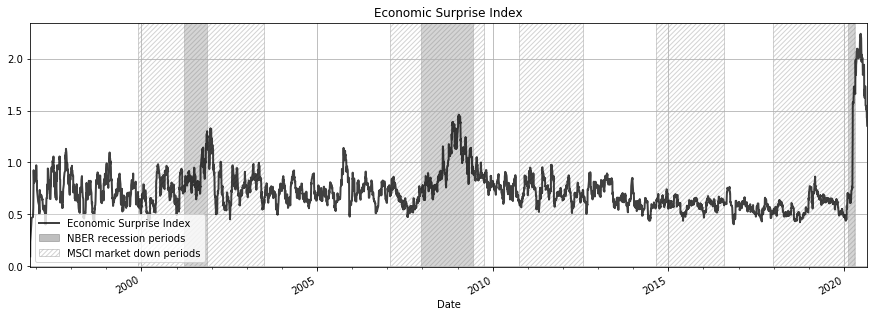

In [87]:
### RUN TO TESTING: ECONOMIC SURPRISE INDEX VISUALIZING:

### Visualizing pattern defining:
list_style_pattern = ['b--', 'y--', 'g--', 'r--', 'c--', 'm--', 'gray', 'k-']
#### Global index data loading:
#ser_global_index = pd.read_hdf('Data_Files/Source_Files/Diag_Eco_Indices.h5', key = 'global_diagonal_full_mom')
#ser_global_index.name = 'Global Index'
### Plot creating:
#ax_diag = pd.concat([ser_global_index, ser_surprise], axis = 1).ffill().dropna()\
#            .plot(figsize = (15, 5), title = 'Economic Surprise Index', style = list_style_pattern[-2 :], linewidth = 2.0, alpha = 0.75, grid = True, x_compat = True)
ax_diag = ser_surprise.plot(figsize = (15, 5), title = 'Economic Surprise Index', 
                            style = list_style_pattern[-1], linewidth = 2.0, alpha = 0.75, grid = True, x_compat = True)
### Recession periods adding:
df_nber_period = pd.read_hdf(str_path_nber_hdf, key = str_nber_periods_key)
for iter_num, iter_row in enumerate(df_nber_period.itertuples()):
    ax_diag.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'gray', edgecolor = 'gray', alpha = 0.50, 
                    label = '_' * iter_num + 'NBER recession periods')
### Market down periods adding:
df_msci_period = pd.read_hdf(str_path_msci_hdf, key = str_msci_market_down_key)
for iter_num, iter_row in enumerate(df_msci_period.itertuples()):
    ax_diag.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'white', edgecolor = 'gray', alpha = 0.35, hatch = '/////', 
                    label = '_' * iter_num + 'MSCI market down periods')         
### Plot drawing:    
ax_diag.xaxis.set_major_locator(mdates.YearLocator(base = 5))
ax_diag.xaxis.set_minor_locator(mdates.YearLocator(base = 1))
ax_diag.legend(loc = 'lower left')    
plt.show()

In [120]:
### RUN TO RE-EXPORT DATA: BY DATE WEIGHTED AVERAGE FORECAST STD CALCULATION

### Defining index vector average calculator:
def data_date_stdev(df_date):
    if (len(df_date.index) == 0):
        return np.NaN
    else:
        flo_stdev = (df_date['Relative_Std_Z'] *  df_date['Full_Weight']).sum() / df_date['Full_Weight'].sum()
        return flo_stdev
    
### Forecast standard deviation data loading:
df_stdev = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_stdev_source)
### Relative standard deviation calculation:
df_stdev['Relative_Std'] = (df_stdev['Forecast_Std'] / df_stdev['Survey_Median']).abs()
### Infinite values replacing:
ser_relative_max = df_stdev['Relative_Std'].replace(np.inf, np.NaN).groupby('Index_Name').max()
ser_relative_max.name = 'Relative_Max'
df_stdev = df_stdev.join(ser_relative_max)
df_stdev.loc[df_stdev['Relative_Std'] == np.inf, 'Relative_Std'] = df_stdev.loc[df_stdev['Relative_Std'] == np.inf, 'Relative_Max']
### By Index std standartization:
df_stdev['Relative_Std_Z'] = df_stdev['Relative_Std'] * int_winsorize_bound / df_stdev['Relative_Max']
### Forward filling weights and standartized values:
df_stdev_std = df_stdev[['Relative_Std_Z', 'Full_Weight']].unstack('Index_Name').sort_index().ffill().stack(dropna = False).swaplevel().sort_index()
### Average surprise caclulation:
ser_stdev = df_stdev_std.dropna().groupby('Data_Date').apply(data_date_stdev)
ser_stdev.name = 'Forecast Std Index'
ser_stdev.index.name = 'Date'

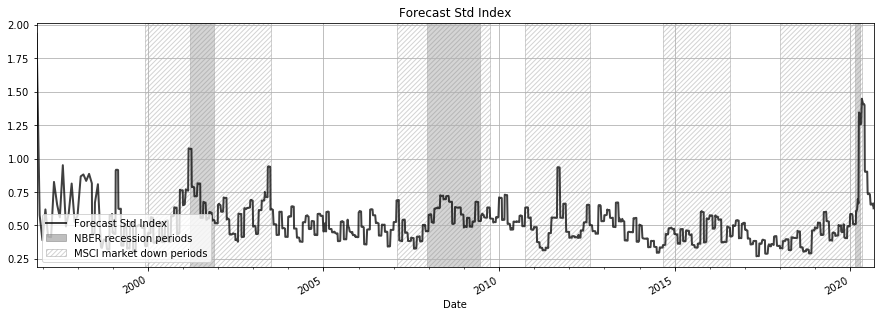

In [122]:
### RUN TO TESTING: FORECAST STD INDEX VISUALIZING:

### Visualizing pattern defining:
list_style_pattern = ['b--', 'y--', 'g--', 'r--', 'c--', 'm--', 'gray', 'k-']
#### Global index data loading:
#ser_global_index = pd.read_hdf('Data_Files/Source_Files/Diag_Eco_Indices.h5', key = 'global_diagonal_full_mom')
#ser_global_index.name = 'Global Index'
### Plot creating:
#ax_diag = pd.concat([ser_global_index, ser_surprise], axis = 1).ffill().dropna()\
#            .plot(figsize = (15, 5), title = 'Economic Surprise Index', style = list_style_pattern[-2 :], linewidth = 2.0, alpha = 0.75, grid = True, x_compat = True)
ax_diag = ser_stdev.plot(figsize = (15, 5), title = 'Forecast Std Index', 
                            style = list_style_pattern[-1], linewidth = 2.0, alpha = 0.75, grid = True, x_compat = True)
### Recession periods adding:
df_nber_period = pd.read_hdf(str_path_nber_hdf, key = str_nber_periods_key)
for iter_num, iter_row in enumerate(df_nber_period.itertuples()):
    ax_diag.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'gray', edgecolor = 'gray', alpha = 0.50, 
                    label = '_' * iter_num + 'NBER recession periods')
### Market down periods adding:
df_msci_period = pd.read_hdf(str_path_msci_hdf, key = str_msci_market_down_key)
for iter_num, iter_row in enumerate(df_msci_period.itertuples()):
    ax_diag.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'white', edgecolor = 'gray', alpha = 0.35, hatch = '/////', 
                    label = '_' * iter_num + 'MSCI market down periods')         
### Plot drawing:    
ax_diag.xaxis.set_major_locator(mdates.YearLocator(base = 5))
ax_diag.xaxis.set_minor_locator(mdates.YearLocator(base = 1))
ax_diag.legend(loc = 'lower left')    
plt.show()